In [1]:
#!pip install mlxtend

import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow_model_optimization.quantization.keras import vitis_quantize
from tensorflow.keras.utils import plot_model
import os

from bmis_emg_utils import * 

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn import metrics
from sklearn.metrics import classification_report 
import matplotlib

2023-06-13 08:47:24.804329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2023-06-13 08:47:24.804342: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
subject = 12
no_gesture = 7
fs = 200

notch_freq = 60.0
quality_factor = 30.0
fc = 10.0
fh = 99.0
order = 5
window_time = 200
overlap = 50
no_channel = 8

In [3]:
data, label = get_data_subject_specific(subject, no_gesture, fs, notch_freq, quality_factor, fc, fh, order,
                              window_time, overlap, no_channel)
print('The total data shape is {} and label is {}'.format(data.shape, label.shape))

The total data shape is (3127, 8, 40) and label is (3127, 1)


In [4]:
np.unique(label)

array([0., 1., 2., 3., 4., 5., 6.])

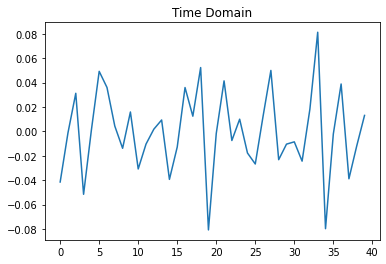

In [5]:
get_time_domain_plot(data[0,0,:])

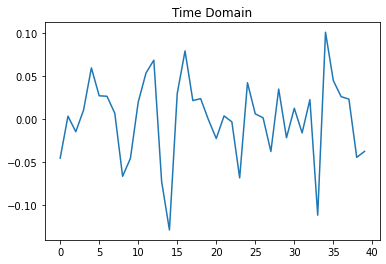

In [6]:
get_time_domain_plot(data[1,0,:])

In [7]:
gesture_list = ['LDG', 'MRDG', 'TFSG', 'PPG', 'PG', 'Cut', 'Rest']

In [8]:
X_train, y_train, X_test, y_test = spilt_data(data, label, ratio=0.1)
print('Training Set is{} Test Set {}'.format(X_train.shape, X_test.shape))

Training Set is(2814, 8, 40) Test Set (313, 8, 40)


In [9]:
# Expanding the input feature shape

X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
print('Expanded Dimension are {}'.format(X_train.shape))
input_size = X_train.shape[1:]
print(input_size)

Expanded Dimension are (2814, 8, 40, 1)
(8, 40, 1)


In [10]:
result = pd.DataFrame({
        'Subject': [0],
        'Validation_result':[0],
        'Test_result_32_bit':[0],
        'Test_result_8_bit_ptq':[0],
        'Test_result_8_bit_qat':[0]
        })

STEP 2: TRAINING AND HYPER-PARMATER TUNNING

In [11]:
def emg_net():
    
    inputs = tf.keras.Input(shape=input_size)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=input_size)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(151, activation='relu')(x)
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="BMIS-EMG-NET")
    
    return model

In [12]:
model = emg_net()
model.summary()

Model: "BMIS-EMG-NET"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 40, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 6, 38, 32)         320       
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 36, 32)         9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 18, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 18, 32)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                      

2023-06-13 08:47:38.288474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2023-06-13 08:47:38.288521: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-13 08:47:38.288566: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-06-13 08:47:38.288955: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-07, clipnorm=1)
ls = 'sparse_categorical_crossentropy'
mtr = 'accuracy'

n_batches = 16
n_epochs = 30
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
checkpoint_path = os.path.join('../checkpoint/full', str(subject))

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
     

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath = checkpoint_path, save_best_only=True, monitor='accuracy', vebrose=1)

num_folds = 3
fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=False)
accuracy_per_fold = []
loss_per_fold = []

In [ ]:
for train, test in kfold.split(X_train, y_train):
    
    model = emg_net()
    model.compile(optimizer=opt, loss=ls, metrics=mtr)
    
    print('---------------------------------------------------')
    print(f'Training for fold {fold_no} -------')
    
    history = model.fit(X_train[train], y_train[train], callbacks=[early_stop, checkpoint_callback],
                        batch_size=n_batches, epochs= n_epochs, verbose=1)
    
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold  {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] *100)
    loss_per_fold.append(scores[0])
          
    fold_no = fold_no + 1    

In [ ]:
print("Average Score per fold ")

for i in range(0, len(accuracy_per_fold)):
    print('-----------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('-----------------------------------------------')
print('Average Metrics for all folds: ')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('-----------------------------------------------')

In [ ]:
validation_result = np.mean(accuracy_per_fold)
print(f'The three-fold cross validation result is: {validation_result}%')

In [ ]:
#best_model_path = os.path.join(checkpoint_path, 'best_model')best_
model = tf.keras.models.load_model(checkpoint_path)

In [ ]:
uqt_test_loss, uqt_test_accuracy = model.evaluate(X_test, y_test)
full_test_accuracy = uqt_test_accuracy * 100
print(f'Accuracy of the Unquantized_model {full_test_accuracy}%')

In [ ]:
y_predict = model.predict(X_test)
y_predict = np.argmax(y_predict, axis=-1)
precision = precision_score(y_test, y_predict, average='weighted')
recall = recall_score(y_test, y_predict, average='weighted')
f1_score  = f1_score(y_test, y_predict, average='weighted')
#f1_score = 2 * (sensitivity * specificity) / (sensitivity + specificity)

print(f'Precision of the Unquantized_model {precision}')
print(f'Recall of the  PTQ model {recall}')
print(f'F1_score of the QAT model {f1_score}')

In [ ]:
saved_model = '../full_models/EMG-NET-' + str(subject) + '.h5'
model.save(saved_model)

STEP 3: POST TRAINING QUANTIZATION (Int-8)

In [ ]:
calibration_dataset = X_train[0:1000] # Note a minumum of 100 is needed and a maximum of 1000
evaluation_dataset = X_test
evaluation_dataset_gnd = y_test

In [ ]:
saved_float32_model = tf.keras.models.load_model(saved_model)
ptq_quantizer = vitis_quantize.VitisQuantizer(saved_float32_model)
ptq_quantized_model = ptq_quantizer.quantize_model(calib_dataset=calibration_dataset)

In [ ]:
# Evalauting Post training quantization

ptq_quantized_model.compile(loss=ls, metrics=mtr)
ptq_loss, ptq_accuracy = ptq_quantized_model.evaluate(evaluation_dataset, evaluation_dataset_gnd)
ptq_test_accuracy = ptq_accuracy * 100
print(f'Post training quantization accuracy {ptq_test_accuracy}%')

# Saving post training quantization
quantized_model = '../ptq_models/ptq-EMG-NET-' + str(subject) + '.h5'
ptq_quantized_model.save(quantized_model)

In [ ]:
num_folds = 3
fold_no = 1
#kfold_2 = KFold(n_splits=num_folds, shuffle=True)
accuracy_per_fold_2 = []
loss_per_fold_2 = []


checkpoint_path = os.path.join('../checkpoint/qat', str(subject))

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
     

qat_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath = checkpoint_path, save_best_only=True, monitor='accuracy', vebrose=1)

In [ ]:
for train, test in kfold.split(X_train, y_train):
    
    qat_model = emg_net()
    quantizer = vitis_quantize.VitisQuantizer(qat_model, quantize_strategy='8bit_tqt')
    qat_model_set = quantizer.get_qat_model(init_quant=True, calib_dataset=calibration_dataset)
    
    qat_model.compile(optimizer= opt, loss=ls, metrics=mtr)
    
    print('---------------------------------------------------')
    print(f'Quantization Aware Training for fold {fold_no} -------')
    
    qat_history = qat_model.fit(X_train[train], y_train[train],
                                callbacks=[early_stop, qat_checkpoint_callback], batch_size=n_batches, epochs= n_epochs, verbose=1)
    
    qat_scores = qat_model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold  {fold_no}: {qat_model.metrics_names[0]} of {qat_scores[0]}; {qat_model.metrics_names[1]} of {qat_scores[1]*100}%')
    accuracy_per_fold_2.append(scores[1] *100)
    loss_per_fold_2.append(scores[0])
          
    fold_no = fold_no + 1

In [ ]:
print("Average Score per fold ")

for i in range(0, len(accuracy_per_fold_2)):
    print('-----------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold_2[i]} - Accuracy: {accuracy_per_fold_2[i]}%')
print('-----------------------------------------------')
print('Average Metrics for all folds: ')
print(f'> Accuracy: {np.mean(accuracy_per_fold_2)} (+- {np.std(accuracy_per_fold_2)})')
print(f'> Loss: {np.mean(loss_per_fold_2)}')
print('-----------------------------------------------')

In [ ]:
qat_model = tf.keras.models.load_model(qat_checkpoint_path)

In [ ]:
qat_test_loss, qat_test_accuracy = qat_model.evaluate(X_test, y_test)
qat_test_accuracy = qat_test_accuracy * 100
print(f'Quantization Aware Accuracy {qat_test_accuracy}%')

saved_model = '../qat_models/qat-EMG-NET-' + str(subject) + '.h5'
qat_model.save(saved_model)

5. Compiling

In [ ]:
!vai_c_tensorflow2 \
    --model ../ptq_models/ptq-EMG-NET-33.h5 \
    --arch ./arch_ultra96.json \
    --output_dir ../inference_models \
    --net_name subject_33_model 

In [ ]:
input_size = (8, 40, 1)

def emg_net(input_size):

    inputs = tf.keras.Input(shape=input_size)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=input_size)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(151, activation='relu')(x)
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="BMIS-EMG-NET")

    return model




def run_experiment(start_subject=3, stop_subject=4, split_ratio=0.2, no_gesture=7, fs=200, notch_freq=60.0, 
                    quality_factor=30.0, fc=10.0, fh=99.0,
                  order=5, window_time=200, overlap=60, no_channel=8, opt='adam', 
                   ls='sparse_categorical_crossentropy', mtr='accuracy', n_batches=16, n_epochs=30):
    
    result = pd.DataFrame({
        'Subject': [0],
        'Validation_result':[0.0],
        'qat_Validation_result':[0.0],
        'Test_result_32_bit':[0.0],
        'Test_result_8_bit_ptq':[0.0],
        'Test_result_8_bit_qat':[0.0],
        
        'precision_full':[0.0],
        'recall_full':[0.0],
        'f1_score_full':[0.0],

        'precision_ptq':[0.0],
        'recall_ptq':[0.0],
        'f1_score_ptq':[0.0],
        
        'precision_qat':[0.0],
        'recall_qat':[0.0],
        'f1_score_qat':[0.0]
        })
    
    data, label = get_data_subject_specific(start_subject, no_gesture, fs, notch_freq, quality_factor, fc, fh, order,
                              window_time, overlap, no_channel)
    
    
    
    X_train, y_train, X_test, y_test = spilt_data(data, label, ratio=split_ratio)
        
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)
    input_size = X_train.shape[1:]
    
    


    for subject in range(start_subject, (stop_subject+1)):
        
        fold_no = 1
        num_folds = 3
        accuracy_per_fold = []
        loss_per_fold = []
        qat_accuracy_per_fold = []
        qat_loss_per_fold = []
        kfold = KFold(n_splits=num_folds, shuffle=False)
        
        
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        print(f'Training and Evaluation for subject {subject}')
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        data, label = get_data_subject_specific(subject, no_gesture, fs, notch_freq, quality_factor, fc, fh, order,
                              window_time, overlap, no_channel)
        
        
        X_train, y_train, X_test, y_test = spilt_data(data, label, ratio=split_ratio)
        
        X_train = np.expand_dims(X_train, axis=3)
        X_test = np.expand_dims(X_test, axis=3)
        input_size = X_train.shape[1:]
        
        calibration_dataset = X_train[0:1000] # Calibration data needed to quantize the model
        print(f'Input shape to the EMG-Net Model is: {input_size}')
        
        for train, test in kfold.split(X_train, y_train):
    
            model = emg_net(input_size)
            model.compile(optimizer=opt, loss=ls, metrics=mtr)
            checkpoint_path = os.path.join('../checkpoint/full', str(subject))

            if not os.path.exists(checkpoint_path):
                os.makedirs(checkpoint_path)

            early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
            checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                        filepath = checkpoint_path, save_best_only=True, monitor='accuracy', vebrose=1)
    
            print('---------------------------------------------------')
            print(f'Training Unquantized Model for fold {fold_no} -------')
    
            history = model.fit(X_train[train], y_train[train], callbacks=[early_stop, checkpoint_callback], 
                                batch_size=n_batches, epochs= n_epochs, verbose=1)
    
            scores = model.evaluate(X_train[test], y_train[test], verbose=0)
            print(f'Score for fold  {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
            accuracy_per_fold.append(scores[1] *100)
            loss_per_fold.append(scores[0])
          
            
            
            print('######################################################')
            print('Quantization Aware Training')
            
            qat_checkpoint_path = os.path.join('../checkpoint/qat', str(subject))

            if not os.path.exists(qat_checkpoint_path):
                os.makedirs(qat_checkpoint_path)
     

            qat_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                        filepath = qat_checkpoint_path, save_best_only=True, monitor='accuracy', vebrose=1)
            
            qat_model = emg_net(input_size)
            quantizer = vitis_quantize.VitisQuantizer(qat_model, quantize_strategy='8bit_tqt')
            qat_model_set = quantizer.get_qat_model(init_quant=True, calib_dataset=calibration_dataset)

            qat_model.compile(optimizer= opt, loss=ls, metrics=mtr)

            print('---------------------------------------------------')
            print(f'Quantization Aware Training for fold {fold_no} -------')

            qat_history = qat_model.fit(X_train[train], y_train[train],
                                        callbacks=[early_stop, qat_checkpoint_callback], 
                                        batch_size=n_batches, epochs= n_epochs, verbose=1)

            qat_scores = qat_model.evaluate(X_train[test], y_train[test], verbose=0)
            print(f'QAT Score for fold  {fold_no}: {qat_model.metrics_names[0]} of {qat_scores[0]}; {qat_model.metrics_names[1]} of {qat_scores[1]*100}%')
            qat_accuracy_per_fold.append(qat_scores[1] *100)
            qat_loss_per_fold.append(scores[0])

            fold_no = fold_no + 1
        
        print("Average Full Bit Validation Score per fold ")

        for i in range(0, len(accuracy_per_fold)):
            print('-----------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
        print('-----------------------------------------------')
        print('Average Metrics for all folds: ')
        print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print('-----------------------------------------------')
        print('############################################################')
        print(f'Training Ended for subject {subject}')
        print('############################################################')
        
        validation_result = np.mean(accuracy_per_fold)
        qat_validation_result = np.mean(qat_accuracy_per_fold)
        
        ######### Load the best model from checkpoint. ################
        model = tf.keras.models.load_model(checkpoint_path)
        
        ############# Evaluating 32-bit Model ##########################
        print('############################################################')
        print(f'Evaluating Unquantized Model')
        print('############################################################')
        uqt_test_loss, uqt_test_accuracy = model.evaluate(X_test, y_test)
        full_test_accuracy = uqt_test_accuracy * 100
        print(f'Accuracy of the Unquantized_model {full_test_accuracy}%')
        
        
        y_predict = model.predict(X_test)
        y_predict = np.argmax(y_predict, axis=-1)
   
        precision = precision_score(y_test, y_predict, average='weighted')
        recall = recall_score(y_test, y_predict, average='weighted')
        f1_score_full = 2 * (precision * recall) / (precision + recall)


        
        print(f'Precision of the Unquantized model {precision}')
        print(f'Recall of the Unquantized model {recall}')
        print(f'F1_score of the Unquantized model {f1_score_full}')
    
        
        ############ Save the full model as .h5. This will be used for quantization #####
        saved_model = '../full_models/EMG-NET-' + str(subject) + '.h5'
        model.save(saved_model)
        
        
        
        ############### Post-Training Quantization ########################
        saved_float32_model = tf.keras.models.load_model(saved_model)
        ptq_quantizer = vitis_quantize.VitisQuantizer(saved_float32_model)
        ptq_model = ptq_quantizer.quantize_model(calib_dataset=calibration_dataset)
        
        
        ############# Evalauting PTQ Model #######################################
        print('############################################################')
        print(f'Evaluating PTQ Model')
        print('############################################################')

        ptq_model.compile(loss=ls, metrics=mtr)
        ptq_loss, ptq_test_accuracy = ptq_model.evaluate(X_test, y_test)
        ptq_test_accuracy = ptq_test_accuracy * 100
        print(f'Accuracy of the PTQ model {ptq_test_accuracy}%')
        
        
            
        ptq_y_predict = ptq_model.predict(X_test)
        ptq_y_predict = np.argmax(ptq_y_predict, axis=-1)
        ptq_precision = precision_score(y_test, ptq_y_predict, average='weighted')
        ptq_recall = recall_score(y_test, ptq_y_predict, average='weighted')
        ptq_f1_score = 2 * (ptq_precision * ptq_recall) / (ptq_precision + ptq_recall)
        
        
        print(f'Precision of the PTQ model {ptq_precision}')
        print(f'Recall of the PTQ model {ptq_recall}')
        print(f'F1_score of the PTQ model {ptq_f1_score}')

        # Saving PTQ model; Can be complied for depolyment #######  
        ptq_quantized_model = '../ptq_models/ptq-EMG-NET-' + str(subject) + '.h5'
        ptq_model.save(ptq_quantized_model)
        
        
        ############# Evalauting QAT Model ###################################
        
        ## Load Best QAT Model
        qat_model = tf.keras.models.load_model(qat_checkpoint_path)
        
        ## ######### Evaluate QAT Model###############################################
        print('############################################################')
        print(f'Evaluating QAT Model')
        print('############################################################')
        
        qat_test_loss, qat_test_accuracy = qat_model.evaluate(X_test, y_test)
        qat_test_accuracy = qat_test_accuracy * 100
        print(f'Accuracy of the QAT model {qat_test_accuracy}%')
        
        
        qat_y_predict = qat_model.predict(X_test)
        qat_y_predict = np.argmax(qat_y_predict, axis=-1)
        qat_precision = precision_score(y_test, qat_y_predict, average='weighted')
        qat_recall = recall_score(y_test, qat_y_predict, average='weighted')
        qat_f1_score = 2 * (qat_precision * qat_recall) / (qat_precision + qat_recall)
        
        
        print(f'Precision of the QAT model {qat_precision}')
        print(f'Recall of the QAT model {qat_recall}')
        print(f'F1_score of the QAT model {qat_f1_score}')
        
        # Saving QAT model; Can be complied for depolyment #######  
        qat_quantized_model = '../qat_models/qat-EMG-NET-' + str(subject) + '.h5'
        qat_model.save(qat_quantized_model)
        
        
        result.at[subject-1, 'Subject'] = subject
        result.at[subject-1, 'Validation_result'] = validation_result
        result.at[subject-1, 'qat_Validation_result'] = qat_validation_result
        result.at[subject-1, 'Test_result_32_bit'] = full_test_accuracy
        result.at[subject-1, 'Test_result_8_bit_ptq'] = ptq_test_accuracy
        result.at[subject-1, 'Test_result_8_bit_qat'] = qat_test_accuracy
        
        result.at[subject-1, 'precision_full'] = precision 
        result.at[subject-1, 'recall_full'] = recall
        result.at[subject-1, 'f1_score_full'] = f1_score_full
   
        result.at[subject-1, 'precision_ptq'] = ptq_precision 
        result.at[subject-1, 'recall_ptq'] = ptq_recall
        result.at[subject-1, 'f1_score_ptq'] = ptq_f1_score
        
        result.at[subject-1, 'precision_qat'] = qat_precision 
        result.at[subject-1, 'recall_qat'] = qat_recall
        result.at[subject-1, 'f1_score_qat'] = qat_f1_score

        save_path = str(start_subject)+'_to_'+str(stop_subject)+'_EMG_Net.csv'
        save_path = os.path.join('../results', save_path)
        result.to_csv(save_path, index=False)

In [ ]:
run_experiment()

Storing Data for On-device Inference

In [ ]:
import scipy.io
import numpy as np
import os
from bmis_emg_utils import * 

In [ ]:
def save_on_device_data(start_subject, end_subject):
    

    
    
    for subject in range(start_subject, end_subject+1):
        
        fs = 200

        notch_freq = 60.0
        quality_factor = 30.0
        fc = 10.0
        fh = 99.0
        order = 5
        window_time = 200
        overlap = 50
        no_channel = 8

        no_gesture = 7
        concat_data = []
        concat_label = []
        on_device_data_path = '../on-device/data/' + str(subject) + '.mat'
        
        data, label = get_data_subject_specific(subject, no_gesture, fs, notch_freq, 
                                                quality_factor, fc, fh, order,
                                                  window_time, overlap, no_channel)        
        

        for i in range(no_gesture):
            random_items = np.random.choice(np.where(np.squeeze(label == i))[0], size=5, replace=False)
            on_device_data = data[random_items]
            on_device_label = label[random_items]

            concat_data.append(on_device_data)
            concat_label.append(on_device_label)

        new_data = np.concatenate(concat_data, axis=0)
        new_label = np.concatenate(concat_label, axis=0)   
        
        new_data, new_label = shuffle_data(new_data, new_label)
        
        data_dict = {'data': new_data, 'label':new_label}
        
        
        scipy.io.savemat(on_device_data_path, data_dict)
    
    print('%%%% Finished Storing Data%%%')

In [ ]:
save_on_device_data(start_subject=12, end_subject=33)

In [ ]:
on_device_data_path = '../on-device/data/' + str(13) + '.mat'
on_device_data = scipy.io.loadmat(on_device_data_path)

In [ ]:
das = on_device_data['data']
labs = on_device_data['label']

In [ ]:
np.unique(labs)

In [ ]:
fs = 200

notch_freq = 60.0
quality_factor = 30.0
fc = 10.0
fh = 99.0
order = 5
window_time = 200
overlap = 50
no_channel = 8
subject =12
no_gesture = 7
concat_data = []
concat_label = []
on_device_data_path = '../on-device/data/' + str(subject) + '.mat'

data, label = get_data_subject_specific(subject, no_gesture, fs, notch_freq, 
                                        quality_factor, fc, fh, order,
                                          window_time, overlap, no_channel)

In [ ]:
label.shape